## Bagging Classifier (from Decision Tree)

From the previous three combinations, we get that the best performing hyperparameter combination among them is:
- `max_depth` = 8
- `n_estimators` = 40

However, we have only tested three random combinations. To find the best performing hyperparameter combination, here I use a Grid Search strategy for the combinations of the two parameters, where each of them are within the following ranges, respectively:
- `max_depth` $\in$ [4,8]
- `n_estimators` $\in$ [30,50]

Find the best performing hyperparameter combination that gives the highest validation score. 

Then, use this best performing hyperparameter combination to train the model and predict the outcome.

Note that in this model we change the optimal features for each period.

## Table of Content

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

pd.set_option('use_inf_as_na', True)
from collections import Counter

In [3]:
raw_data = pd.read_pickle(r'..\HW1_Decision Tree\dataset.pkl')

In [4]:
data = raw_data[raw_data['market_cap'] > 1000.0]

In [5]:
data.fillna(0.0,inplace=True)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Insert a column in the data set where the entries are： (1) 1 if the stock outperforms SPY in the earnings period; (2) -1 if it underperforms or has the same return

In [6]:
def f(x):
    if x > 0:
        return 1
    else:
        return -1

In [7]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

### Use the period 2007-04-30 to 2010-04-30 to train the model

In [9]:
df_1 = data.loc['2007-04-30':'2010-04-30']

### Use the period 2010-07-31 to 2010-10-31 to find the optimal features

In [10]:
df_valid = data.loc['2010-07-31':'2010-10-31']

In [11]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [12]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [13]:
y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']

In [14]:
y_1 = y_1.values
y_valid = y_valid.values

### Grid Search
Use a Grid Search strategy for the combinations of the two parameters, where each of them are within the following ranges, respectively:
- `max_depth` $\in$ [4,8]
- `n_estimators` $\in$ [30,50]

Find the best performing hyperparameter combination that gives the highest validation score. 

In [15]:
score = 0
best_depth = 4
best_n = 30
for i in range(4,9):
    print("max_depth: ",i)
    for j in range(30,51):
        t_clf = DecisionTreeClassifier(min_samples_leaf = 2400, max_depth = i)
        bg_clf = BaggingClassifier(t_clf, n_estimators=j, random_state=123, n_jobs=1)
        bg_clf.fit(train_1,y_1)
        if score < bg_clf.score(valid,y_valid):
            score = bg_clf.score(valid,y_valid)
            best_depth = i
            best_n = j

max_depth:  4
max_depth:  5
max_depth:  6
max_depth:  7
max_depth:  8


In [16]:
print(score)
print(best_depth)
print(best_n)

0.5622317596566524
4
31


### Use the best hyperparameter combination to train the model and predict the outcome

In [17]:
t_clf = DecisionTreeClassifier(min_samples_leaf=2400, max_depth=best_depth)

In [18]:
bg_clf = BaggingClassifier(t_clf, n_estimators=best_n, random_state=123, n_jobs=1)

In [19]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
    print("feature_importances.shape: ", feature_importances.shape)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

In [20]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(10):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [21]:
def bagging_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

#### Backtest the performance of the model over the period 2010-01-01 to 2018-12-31    
There are #(5*4 + 3 = 23) training frames in total

In [22]:
# backtest
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(22)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [23]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [24]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

#### Change the optimal features each period

In [25]:
optimal_features = []

for i in range(len(training_data)):
    print(i)
    profits = []
    feat=[]

    bg_clf.fit(training_data[i],training_labels[i])
    fi = bagging_feat_importance(bg_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = test_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    bg_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = bagging_profit_importance(bg_clf,validation,test_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        bg_clf.fit(train,training_labels[i])
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * test_frames[i]['next_period_return']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]

    optimal_features.append(optim_feats)

0
feature_importances.shape:  (31, 725)
1
feature_importances.shape:  (31, 725)
2
feature_importances.shape:  (31, 725)
3
feature_importances.shape:  (31, 725)
4
feature_importances.shape:  (31, 725)
5
feature_importances.shape:  (31, 725)
6
feature_importances.shape:  (31, 725)
7
feature_importances.shape:  (31, 725)
8
feature_importances.shape:  (31, 725)
9
feature_importances.shape:  (31, 725)
10
feature_importances.shape:  (31, 725)
11
feature_importances.shape:  (31, 725)
12
feature_importances.shape:  (31, 725)
13
feature_importances.shape:  (31, 725)
14
feature_importances.shape:  (31, 725)
15
feature_importances.shape:  (31, 725)
16
feature_importances.shape:  (31, 725)
17
feature_importances.shape:  (31, 725)
18
feature_importances.shape:  (31, 725)
19
feature_importances.shape:  (31, 725)
20
feature_importances.shape:  (31, 725)
21
feature_importances.shape:  (31, 725)


In [26]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        bg_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = bg_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)


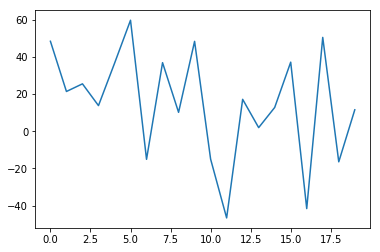

In [27]:
plt.plot(P_L)

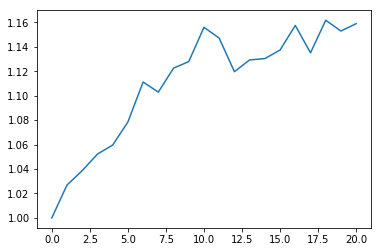

In [28]:
plt.plot(x[1:]);

In [29]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2013-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

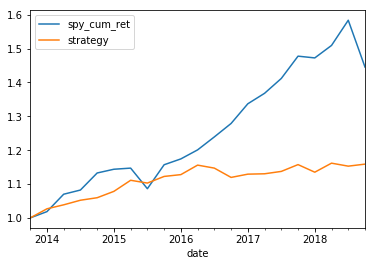

In [30]:
SPY.plot();

In [31]:
SPY = SPY.resample('Y').ffill()

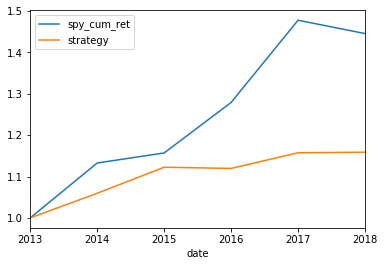

In [32]:
SPY.plot();

In [33]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.0174176347077872


In [34]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.9675171990497211


In [35]:
x[-1]

1.1588114461969365

In [36]:
SPY['spy_cum_ret'][-1]

1.4453449999999985

In [37]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.08857233274597497

In [38]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.8730297306921513

In [39]:
alpha = np.mean(residual_ret)
alpha

0.02387324013403609

## Results

Using the Grid Search strategy, we find the best combination of hyperparameter is: `max_depth`=4 , `n_estimator`=31, where the score of the validation is 0.5622.

Using this combination of parameter, we get the results of the model:
- Sharpe ratio for the strategy is 1.0174
- Sharpe ratio for SPY is 0.9675
- Information ratio for the strategy is 0.8730
- Alpha for the strategy is 0.0239